In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Import Python Modules

In [17]:
# Main PODPAC library
import podpac
podpac.settings['DEFAULT_CACHE'] = []
podpac.settings['RAM_CACHE_ENABLED'] = False

# Data source nodes
from podpac.datalib.smap_egi import SMAP
from podpac.datalib.drought_monitor import DroughtMonitorCategory, DroughtCategory

# Algorithm nodes
from podpac.algorithm import YearSubstituteCoordinates, Arithmetic

# Retrieve Data 
## Computed Drought Categories
* We computed these categories from historical SMAP data and staged the results on AWS S3. 
* To access these datasets, our specific AWS credentials are required.

In [3]:
# AWS bucket where data lives
bucket = "podpac-internal-test"
# Name of the file, in 'zarr' format
store = "drought_parameters.zarr"
# Path used by PODPAC to retrieve the data
source = 's3://%s/%s' % (bucket, store)

# Create the node that points to the .zarr file on S3
d0_source = DroughtMonitorCategory(datakey='d0', source=source)

# All of our data uses the year '2018', but really describe a climatology. 
# Hence, any incoming requests should have the year replaced by '2018'
year = '2018'

# This algorithm node take the incoming request, replaces the year by 2018, evaluates the d0_source node, 
# then substitutes the original date in the result
d0 = YearSubstituteCoordinates(year=year, source=d0_source, substitute_eval_coords=True)

# Repeat for the other categories
d1 = YearSubstituteCoordinates(source=DroughtMonitorCategory(datakey='d1', source=source), year=year, substitute_eval_coords=True)
d2 = YearSubstituteCoordinates(source=DroughtMonitorCategory(datakey='d2', source=source), year=year, substitute_eval_coords=True)
d3 = YearSubstituteCoordinates(source=DroughtMonitorCategory(datakey='d3', source=source), year=year, substitute_eval_coords=True)
d4 = YearSubstituteCoordinates(source=DroughtMonitorCategory(datakey='d4', source=source), year=year, substitute_eval_coords=True)

## Raw SMAP Soil Moisture Data
* We retrieve this data from NSIDC through the EGI (Earthdata Gateway Interface). 
* We retrieve level 3 data that have AM and PM returns, and we composite them together.

In [4]:
source = 's3://%s/%s' % (bucket, 'SPL3SMP_E.002_9km_aid0001.zarr')
source2 = 's3://%s/%s' % (bucket, 'SPL4SMGP.004_9km_aid0001.zarr')

kwargs = {'dims': ['time', 'lat', 'lon'], 'latkey': 'fakedim0', 'lonkey': 'fakedim1',
          'cf_time': True, 'cf_calendar': 'proleptic_gregorian', 'cf_units': 'days since 2000-01-01',
         'crs': 'epsg:6933', 'nan_vals': [-9999]}
smap_e_am_raw = podpac.data.Zarr(source=source, datakey='Soil_Moisture_Retrieval_Data_AM_soil_moisture', **kwargs)
smap_e_pm_raw = podpac.data.Zarr(source=source, datakey='Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm', **kwargs)
smap_e_am_qf = podpac.data.Zarr(source=source, datakey='Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag', **kwargs)
smap_e_pm_qf = podpac.data.Zarr(source=source, datakey='Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm', **kwargs)

smap_e_am = podpac.algorithm.Arithmetic(A=smap_e_am_raw, B=smap_e_am_qf,
                                       eqn='((B <= 1) / (B <= 1)) * A ')
smap_e_pm = podpac.algorithm.Arithmetic(A=smap_e_pm_raw, B=smap_e_pm_qf,
                                       eqn='((B <= 1) / (B <= 1)) * A ')


smap_L4 = podpac.data.Zarr(source=source2, datakey='Geophysical_Data_sm_surface', **kwargs)

smap = podpac.compositor.OrderedCompositor(sources=[smap_e_am,
                                                    smap_e_pm,
                                                    smap_L4
                                                   ], source='SMAP L3 AM/PM Combined')

In [5]:
# Check The Coordinates
# coords2 = podpac.Coordinates([podpac.clinspace(50, 23, 256), podpac.clinspace(-126, -66, 256), '2019-05-19'],
#                             ['lat', 'lon', 'time'])
# o = smap.eval(coords2)
# o.plot(vmin=0, vmax=1)

In [6]:
# Get combined smap data
# smap_e_am = SMAP(product='SPL3SMP_E_AM', page_size=40)
# smap_e_pm = SMAP(product='SPL3SMP_E_PM', page_size=40)
# smap = podpac.compositor.OrderedCompositor(sources=[smap_e_am,
#                                                     smap_e_pm,
#                                                    ], source='SMAP L3 AM/PM Combined')

# Create algorithm to convert raw SMAP data to drought categories
* We use an Arithmetic node computes pixel-wise results using an arbitrary equation
* The inputs come from the previously-created nodes, with an A, B, C,... naming convention

In [19]:
# Create the drought Categorization algorithm
alg = DroughtCategory(d0=d0, d1=d1, d2=d2, d3=d3, d4=d4, soil_moisture=smap)

# Test the PODPAC Algorithm Locally
## Create Coordinates
* The nodes will be evaluated at these coordinates. 
* **Note**: the time series of the categories and the SMAP data do not line up, but PODPAC deals with the automatically using nearest-neighbor interpolation (by default). 

In [8]:
coords = podpac.Coordinates([43, -72,
                             podpac.crange('2019-04-12', '2019-07-10', '3,D')],
                            ['lat', 'lon', 'time'])

## Evaluate the Node Locally

In [20]:
# Most of the execution time comes from retrieving SMAP data via EGI
# The results of this request is cached, so subsequent eval's are fast
o = alg.eval(coords)

In [10]:
podpac.utils.clear_cache(mode='ram')

In [11]:
%%timeit
with podpac.settings:
    podpac.settings['DEFAULT_CACHE'] = []
    podpac.settings['RAM_CACHE_ENABLED'] = False
    podpac.settings["CACHE_OUTPUT_DEFAUL"] = False
    podpac.settings['MULTITHREADING'] = True
    podpac.settings['N_THREADS'] = 32
    alg.eval(coords)

2.55 s ± 122 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%%timeit
with podpac.settings:
    podpac.settings['DEFAULT_CACHE'] = []
    podpac.settings['RAM_CACHE_ENABLED'] = False
    podpac.settings["CACHE_OUTPUT_DEFAUL"] = False
    podpac.settings['MULTITHREADING'] = False
    alg.eval(coords)

5.79 s ± 256 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Examine the results

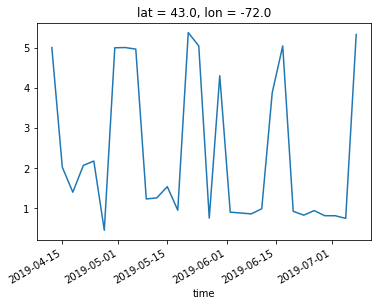

In [21]:
o.plot()

In [22]:
o

<xarray.UnitsDataArray (lat: 1, lon: 1, time: 30)>
array([[[5.009395, 2.019793, 1.395267, 2.064239, 2.174787, 0.444648,
         5.004385, 5.009787, 4.971055, 1.227006, 1.252866, 1.534072,
         0.945038, 5.383892, 5.050078, 0.749056, 4.306948, 0.896968,
         0.875396, 0.853686, 0.98122 , 3.882697, 5.04999 , 0.917755,
         0.822232, 0.935155, 0.80801 , 0.807645, 0.741836, 5.334274]]])
Coordinates:
  * lat      (lat) float64 43.0
  * lon      (lon) float64 -72.0
  * time     (time) datetime64[ns] 2019-04-12 2019-04-15 ... 2019-07-08
Attributes:
    layer_style:  <podpac.core.style.Style object at 0x000002BF60AB9DD8>
    crs:          EPSG:4326

## Evaluate the Node on the Cloud

In [15]:
podpac.settings['S3_JSON_FOLDER'] = 'esip_input2/'
podpac.settings['S3_OUTPUT_FOLDER'] = 'esip_output2/'
podpac.settings['S3_BUCKET_NAME'] = 'podpac-s3'

In [16]:
aws_node = podpac.managers.Lambda(source=alg)
o2 = aws_node.eval(coords)

ERROR:podpac.core.managers.aws:Unhandled error from lambda function


LambdaException: Error in lambda function evaluation:

Error Type: ClientError
Error Message: An error occurred (403) when calling the HeadObject operation: Forbidden
Stack Trace:   File "/var/task/handler.py", line 214, in handler
    s3.download_file(bucket, dependencies, "/tmp/" + dependencies)

  File "/var/task/boto3/s3/inject.py", line 172, in download_file
    extra_args=ExtraArgs, callback=Callback)

  File "/var/task/boto3/s3/transfer.py", line 307, in download_file
    future.result()

  File "/var/task/s3transfer/futures.py", line 106, in result
    return self._coordinator.result()

  File "/var/task/s3transfer/futures.py", line 265, in result
    raise self._exception

  File "/var/task/s3transfer/tasks.py", line 255, in _main
    self._submit(transfer_future=transfer_future, **kwargs)

  File "/var/task/s3transfer/download.py", line 345, in _submit
    **transfer_future.meta.call_args.extra_args

  File "/var/task/botocore/client.py", line 357, in _api_call
    return self._make_api_call(operation_name, kwargs)

  File "/var/task/botocore/client.py", line 661, in _make_api_call
    raise error_class(parsed_response, operation_name)


In [ ]:
o2.plot()

# Export PODPAC Pipelines for development of website
* **Note**, PODPAC kept track of all the nodes used to create the analysis, and recorded this in a light-weight JSON format

In [24]:
def save_json(node, filename):
    with open(filename, 'w') as fid:
        fid.write(node.json_pretty)

# Customize the SMAP node's plot style for WMS Feeds
smap.style.clim = [0, 0.5]
smap.style.colormap = 'gist_earth_r'        
        
save_json(d0, 'pipeline_d0.json')
save_json(d1, 'pipeline_d1.json')
save_json(d2, 'pipeline_d2.json')
save_json(d3, 'pipeline_d3.json')
save_json(d4, 'pipeline_d4.json')
save_json(alg, 'pipeline_category.json')
save_json(smap, 'pipeline_moisture.json')

print (alg.json_pretty)

{
    "DroughtMonitorCategory": {
        "node": "datalib.drought_monitor.DroughtMonitorCategory",
        "attrs": {
            "altkey": "alt",
            "crs": null,
            "datakey": "d0",
            "file_mode": "r",
            "latkey": "lat",
            "lonkey": "lon",
            "timekey": "time"
        },
        "style": {
            "colormap": "gist_earth_r",
            "clim": [
                0,
                0.6
            ]
        },
        "source": "s3://podpac-internal-test/drought_parameters.zarr",
        "interpolation": "nearest"
    },
    "YearSubstituteCoordinates": {
        "node": "core.algorithm.coord_select.YearSubstituteCoordinates",
        "attrs": {
            "substitute_eval_coords": true,
            "year": "2018"
        },
        "inputs": {
            "source": "DroughtMonitorCategory"
        }
    },
    "DroughtMonitorCategory_1": {
        "node": "datalib.drought_monitor.DroughtMonitorCategory",
        "attrs": {